<a href="https://colab.research.google.com/github/athenalobo/Music/blob/main/musicgenreclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing the necessary libraries

In [ ]:
!pip install kaggle
!pip install python_speech_features
!pip install hmmlearn
from python_speech_features import mfcc, logfbank
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
import itertools
import os

importing the dataset through drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Picking one song from the dataset(blues.00001) and extracting mfcc and filterbank features (mfcc is used to concisely represent song waveforms and filterbanks are applied to extract features)

In [ ]:
sampling_freq, audio = wavfile.read("/content/drive/MyDrive/genre/blues/blues.00001.wav")

mfcc_features = mfcc(audio, sampling_freq)
filterbank_features = logfbank(audio, sampling_freq)

Displaying the shapes of the extracted features

In [ ]:
print ('\nMFCC:\nNumber of windows =', mfcc_features.shape[0])
print ('Length of each feature =', mfcc_features.shape[1])
print ('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print ('Length of each feature =', filterbank_features.shape[1])


MFCC:
Number of windows = 2994
Length of each feature = 13

Filter bank:
Number of windows = 2994
Length of each feature = 26


Visualising the mfcc features for the first song of each genre

10
/content/drive/MyDrive/genre/blues/blues.00004.wav 2994
/content/drive/MyDrive/genre/classical/classical.00002.wav 2994
/content/drive/MyDrive/genre/jazz/jazz.00001.wav 2994
/content/drive/MyDrive/genre/country/country.00001.wav 2993
/content/drive/MyDrive/genre/pop/pop.00006.wav 2992
/content/drive/MyDrive/genre/rock/rock.00007.wav 2994
/content/drive/MyDrive/genre/metal/metal.00007.wav 2992
/content/drive/MyDrive/genre/disco/disco.00004.wav 2994
/content/drive/MyDrive/genre/hiphop/hiphop.00005.wav 2992
/content/drive/MyDrive/genre/reggae/reggae.00002.wav 2994


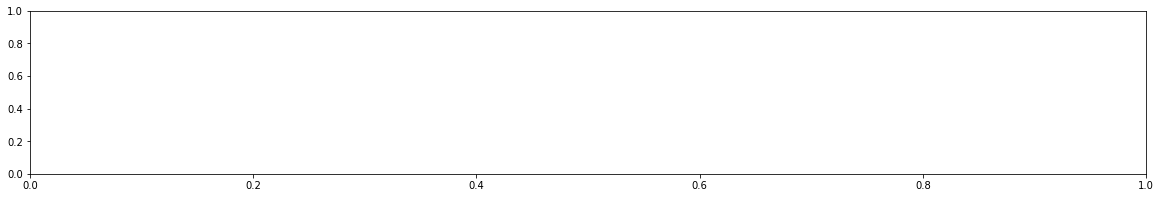

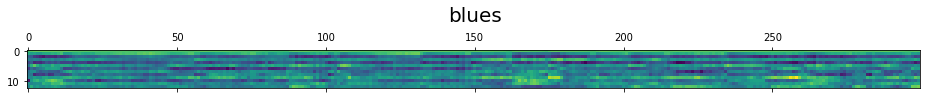

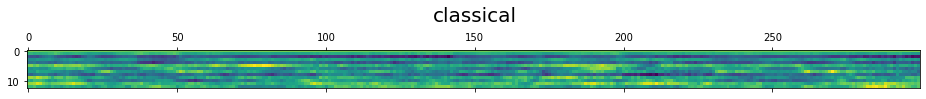

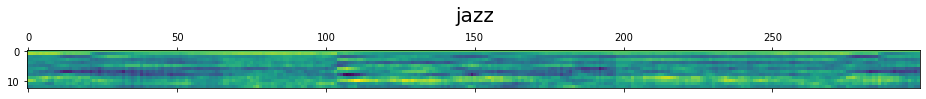

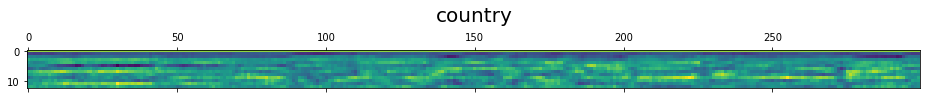

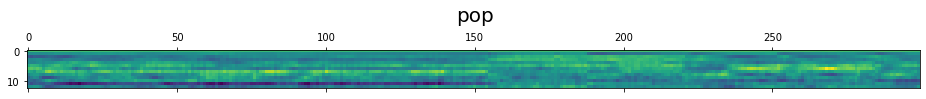

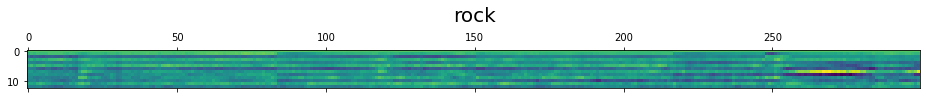

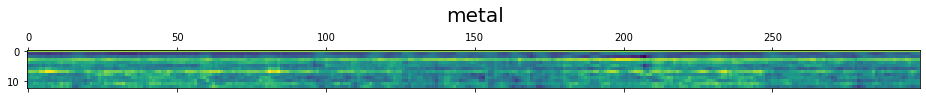

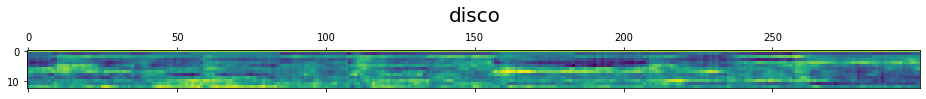

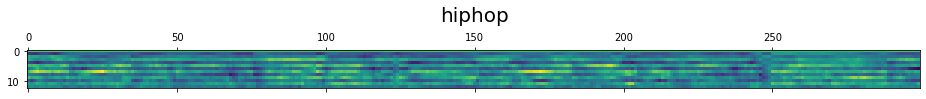

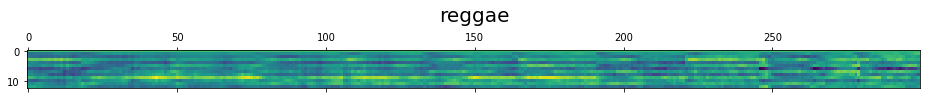

In [ ]:
import glob
import os.path as path
genre_list = ["blues","classical", "jazz", "country", "pop", "rock", "metal", "disco", "hiphop", "reggae"]
print(len(genre_list))
figure = plt.figure(figsize=(20,3))
for idx ,genre in enumerate(genre_list): 
   example_data_path = '/content/drive/MyDrive/genre' 
   
   file_paths = glob.glob(path.join(example_data_path,genre,'*.wav'))
   sampling_freq, audio = wavfile.read(file_paths[0])
   mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
   print(file_paths[0], mfcc_features.shape[0])
   plt.yscale('linear')
   plt.matshow((mfcc_features.T)[:,:300])
   plt.text(150, -10, genre, horizontalalignment='center', fontsize=20)
 
plt.yscale('linear')
plt.show()

Building a class to handle hmm training

In [ ]:
class Trainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=1000):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []

        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components,
                                         covariance_type=self.cov_type, n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type')

    # X is a 2D numpy array where each row is 13D
    def train(self, X):
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))

    # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)


    

        
  

   

training hidden markov models (to do this we iterate over the songs in the subfolder in order to extract the features and append it to a variable.
We should store all trained HMM models, so we will be able to predict the class of unseen songs)

In [ ]:
    hmm_models = []
    input_folder = '/content/drive/MyDrive/genre'

    # Parse the input directory
    for dirname in os.listdir(input_folder):
        # Get the name of the subfolder
        subfolder = os.path.join(input_folder, dirname)

        if not os.path.isdir(subfolder):
            continue

        # Extract the label
        label = subfolder[subfolder.rfind('/') + 1:]

        # Initialize variables
        X = np.array([])
        y_words = []

        # Iterate through the audio files (leaving 1 file for testing in each class)
        for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]:
            # Read the input file
            filepath = os.path.join(subfolder, filename)
            sampling_freq, audio = wavfile.read(filepath)

            # Extract MFCC features
            mfcc_features = mfcc(audio, sampling_freq)

            # Append to the variable X
            if len(X) == 0:
                X = mfcc_features
            else:
                X = np.append(X, mfcc_features, axis=0)

            # Append the label
            y_words.append(label)

        print('X.shape =', X.shape)
        # Train and save HMM model
        hmm_trainer = Trainer(n_components=10)
        hmm_trainer.train(X)
        hmm_models.append((hmm_trainer, label))
        hmm_trainer = None

X.shape = (71856, 13)


X.shape = (71856, 13)


X.shape = (71856, 13)


X.shape = (71949, 13)


X.shape = (71808, 13)


X.shape = (71856, 13)


X.shape = (71808, 13)


X.shape = (71974, 13)


X.shape = (71842, 13)


X.shape = (71856, 13)


Evaluating our models (to do this, we iterate over the test dataset subfolders and extract the features. Then we iterate through all HMM models and pick the one with the highest score)

In [ ]:
    
    # Test files
    input_files = ['/content/drive/MyDrive/test/blues/blues.00000.wav','/content/drive/MyDrive/test/classical/classical.00000.wav','/content/drive/MyDrive/test/jazz/jazz.00000.wav','/content/drive/MyDrive/test/country/country.00000.wav','/content/drive/MyDrive/test/pop/pop.00000.wav','/content/drive/MyDrive/test/rock/rock.00000.wav','/content/drive/MyDrive/test/metal/metal.00000.wav','/content/drive/MyDrive/test/disco/disco.00000.wav',
                   '/content/drive/MyDrive/test/hiphop/hiphop.00000.wav','/content/drive/MyDrive/test/reggae/reggae.00000.wav'
                   ,'/content/drive/MyDrive/test/blues/blues.00021.wav','/content/drive/MyDrive/test/classical/classical.00021.wav','/content/drive/MyDrive/test/jazz/jazz.00021.wav','/content/drive/MyDrive/test/country/country.00021.wav','/content/drive/MyDrive/test/pop/pop.00021.wav','/content/drive/MyDrive/test/rock/rock.00021.wav','/content/drive/MyDrive/test/metal/metal.00021.wav','/content/drive/MyDrive/test/disco/disco.00021.wav',
                   '/content/drive/MyDrive/test/hiphop/hiphop.00021.wav','/content/drive/MyDrive/test/reggae/reggae.00021.wav']
       
    prede=[]
    real=[]

    # Classify input data
    for input_file in input_files:
        # Read input file
        sampling_freq, audio = wavfile.read(input_file)

        # Extract MFCC features
        mfcc_features = mfcc(audio, sampling_freq)

        # Define variables
        max_score = -99999999999999999999999999999
        output_label = None

        # Iterate through all HMM models and pick
        # the one with the highest score
        for item in hmm_models:
            hmm_model, label = item
            score = hmm_model.get_score(mfcc_features)
            if score > max_score:
                max_score = score
                output_label = label

        # Print the output
        lb=input_file[input_file.rfind('/')+1:]
        lub=lb.split(".")[0]
        real.append(lub)
        print("\nTrue:", lub)
        print("Predicted:", output_label)
        prede.append(output_label)



True: blues
Predicted: rock



True: classical
Predicted: classical



True: jazz
Predicted: country



True: country
Predicted: country



True: pop
Predicted: pop



True: rock
Predicted: rock



True: metal
Predicted: disco



True: disco
Predicted: pop



True: hiphop
Predicted: hiphop



True: reggae
Predicted: reggae



True: blues
Predicted: blues



True: classical
Predicted: classical



True: jazz
Predicted: reggae



True: country
Predicted: country



True: pop
Predicted: pop



True: rock
Predicted: rock



True: metal
Predicted: metal



True: disco
Predicted: pop



True: hiphop
Predicted: hiphop

True: reggae
Predicted: hiphop


In [ ]:
print(*real,"/t" )
print(*prede,"/t" )

blues classical jazz country pop rock metal disco hiphop reggae blues classical jazz country pop rock metal disco hiphop reggae /t
rock classical country country pop rock disco pop hiphop reggae blues classical reggae country pop rock metal pop hiphop hiphop /t


This function prints and plots the confusion matrix

In [ ]:
  def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Here, we compute the confusion matrix and visualize it

Normalized confusion matrix
[[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.5]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.5 0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


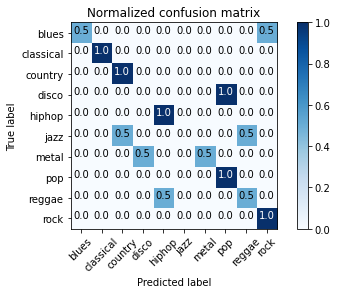

In [ ]:
cm = confusion_matrix(real, prede)
np.set_printoptions(precision=2)
classes = ["blues","classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
plt.figure()
plot_confusion_matrix(cm, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

**For an even better evaluation, It’s always recommended to use the precision and recall metrics for the classification problem. sklearn made it easy for us to have a detailed report about the precision and recall of our multiclass classification. We just need to provide the real and predicted values and our classes names.**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(real, prede, target_names=classes))

              precision    recall  f1-score   support

       blues       1.00      0.50      0.67         2
   classical       1.00      1.00      1.00         2
     country       0.67      1.00      0.80         2
       disco       0.00      0.00      0.00         2
      hiphop       0.67      1.00      0.80         2
        jazz       0.00      0.00      0.00         2
       metal       1.00      0.50      0.67         2
         pop       0.50      1.00      0.67         2
      reggae       0.50      0.50      0.50         2
        rock       0.67      1.00      0.80         2

    accuracy                           0.65        20
   macro avg       0.60      0.65      0.59        20
weighted avg       0.60      0.65      0.59        20



**Conclusion**:-

**That brings us to the end of this tutorial. The performance of our Hidden Markov models is relatively average, and obviously, there is a huge room for improvement.**